In [1]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import tensorflow_datasets as tfds

from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras import layers
# from sklearn import preprocessing
# Make numpy values easier to read.
# np.set_printoptions(precision=3, suppress=True)

# physical_devices = tf.config.list_physical_devices("gpu")
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.backend.set_floatx('float64')
tf.compat.v1.enable_eager_execution()

2023-02-05 10:36:44.256430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# GPUs Available:  0


2023-02-05 10:36:45.914191: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-02-05 10:36:45.914227: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: vn
2023-02-05 10:36:45.914235: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: vn
2023-02-05 10:36:45.914424: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.108.3
2023-02-05 10:36:45.914447: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.108.3
2023-02-05 10:36:45.914454: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.108.3


In [2]:
# preprocessing of data

leakage_train_100 = pd.read_csv("leakage_dataset_train_100.csv")
leakage_train_1000 = pd.read_csv("leakage_dataset_train_1000.csv")
leakage_val_1000 = pd.read_csv("leakage_dataset_validation_1000.csv")

train_ds = leakage_train_100
val_ds = leakage_val_1000

# batch_size = 1

# train_ds = train_ds.repeat()
# train_ds = train_ds.shuffle(buffer_size=1024, seed=0)
# train_ds = train_ds.batch(batch_size=batch_size)
# train_ds = train_ds.prefetch(buffer_size=1)

# val_ds = val_ds.batch(batch_size=batch_size)
# val_ds = val_ds.prefetch(buffer_size=1)


# leakage_train_100.head()
# leakage_val_1000.head()

# #create two output arrays
# def format_output(data):
#     data = data.copy()
#     y1 = data.pop('y1')
#     y1 = np.array(y1)
#     y2 = data.pop('y2')
#     y2 = np.array(y2)
#     return y1, y2

X_train = train_ds.iloc[:,2:].to_numpy()
Y_train = train_ds.iloc[:,:2]

#splitting of x and y variable
# X_train = leakage_train_1000.iloc[:,2:].to_numpy()
# Y_train = leakage_train_1000.iloc[:,:2]

num_rows, num_cols = X_train.shape

X_validation = val_ds.iloc[:,2:].to_numpy()
Y_validation = val_ds.iloc[:,:2]

# scX = preprocessing.StandardScaler()
# X_train = scX.fit_transform(X_train)
# X_validation = scX.transform(X_validation)

# stY = preprocessing.StandardScaler()
# Y_train = stY.fit_transform(Y_train)
# Y_validation = stY.transform(Y_validation)

# Y_train = pd.DataFrame(Y_train, columns = ['y1','y2'])
# Y_validation = pd.DataFrame(Y_validation, columns = ['y1','y2'])

# y1_train, y2_train = format_output(Y_train)
# y1_validation, y2_validation = format_output(Y_validation)

Y_train = Y_train.to_numpy()
Y_validation = Y_validation.to_numpy()

In [3]:
tf.random.set_seed(42) 

# NN architechture - keras Functional API
# Now we have one input layer, 1 hidden layer and 2 output layer - both connected to hidden layer
# Thinking of adding a normalization layer or doing normalization before training
# inputs = tf.keras.layers.Normalization(input_shape=[4,], axis=None)
inputs = tf.keras.Input(shape=(4,))
dense1 = tf.keras.layers.Dense(4, activation='relu')
# dense2_1 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y2')

# dense2_1 = tf.keras.layers.Dense(1, name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, name = 'y2')
dense2_1 = tf.keras.layers.Dense(2)

x=dense1(inputs)

outputs1=dense2_1(x)
# outputs2=dense2_2(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs1, name = 'leakge_functional_model')

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.mean_squared_error,
              metrics = [tf.keras.metrics.MeanSquaredError()]
)

model.fit(X_train, Y_train, epochs=5, batch_size=5, verbose=2, validation_data=(X_validation, Y_validation))

predictions = model.predict(X_validation)

# even for a primilinary result, the loss is pretty good

Model: "leakge_functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
Total params: 30


2023-02-05 10:36:46.042169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
20/20 - 1s - loss: 0.3850 - mean_squared_error: 0.3850 - val_loss: 0.3450 - val_mean_squared_error: 0.3450 - 775ms/epoch - 39ms/step
Epoch 2/5
20/20 - 0s - loss: 0.3582 - mean_squared_error: 0.3582 - val_loss: 0.3336 - val_mean_squared_error: 0.3336 - 201ms/epoch - 10ms/step
Epoch 3/5
20/20 - 0s - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.3360 - val_mean_squared_error: 0.3360 - 191ms/epoch - 10ms/step
Epoch 4/5
20/20 - 0s - loss: 0.3665 - mean_squared_error: 0.3665 - val_loss: 0.3445 - val_mean_squared_error: 0.3445 - 293ms/epoch - 15ms/step
Epoch 5/5
20/20 - 0s - loss: 0.3491 - mean_squared_error: 0.3491 - val_loss: 0.3436 - val_mean_squared_error: 0.3436 - 259ms/epoch - 13ms/step
32/32 [==============================] - 0s 921us/step


rmse of y1:  0.5879764824690431
rmse of y2:  0.5843324933086639


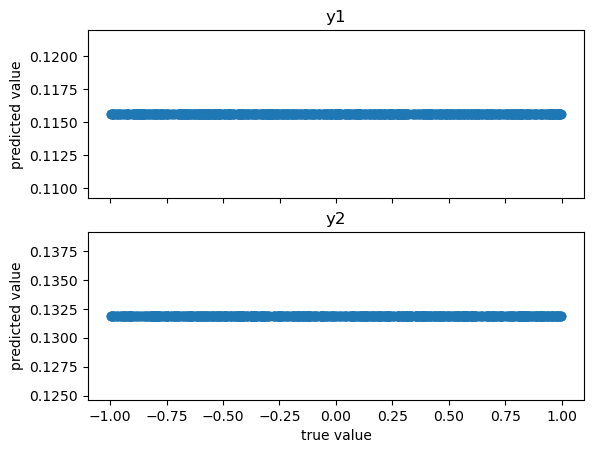

In [4]:
def prediction_accuracy(predictions, Y_validation): 
    predictions = predictions.transpose()
    Y_validation = Y_validation.transpose()
    y1 = predictions[0]
    y2 = predictions[1]
    y1_validation = Y_validation[0]
    y2_validation = Y_validation[1]
    fig, axs = plt.subplots(2)
    # print(y1_validation.shape, y1.shape)
    # print(y2_validation.shape, y2.shape)
    # fig.suptitle('')
    axs[0].scatter(y1_validation, y1)
    axs[0].set_title('y1')
    axs[1].scatter(y2_validation, y2)
    axs[1].set_title('y2')
    for ax in axs.flat:
        ax.set(xlabel='true value', ylabel='predicted value')
    for ax in axs.flat:
        ax.label_outer()

    print("rmse of y1: ", mean_squared_error(y1_validation, y1, squared=False))
    print("rmse of y2: ", mean_squared_error(y2_validation, y2, squared=False))

prediction_accuracy(predictions, Y_validation)

In [5]:
# data Augmentation
# Requires cleaning up

def rotation_matrix(angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return R

def Augmentation_clock(x,y):

    x = x.copy()
    y = y.copy()
    # print(y)
    y_aug = np.transpose(np.matmul(rotation_matrix(-90), np.transpose(y)))
    # print(y_aug)

    temp = x.copy()
    x0 = temp[:,0]
    x1 = temp[:,1]
    x2 = temp[:,2]
    x3 = temp[:,3]

    # print(x0.shape)

    x[:,0] = x3
    x[:,1] = x0
    x[:,2] = x1
    x[:,3] = x2
 
    return x,y_aug


def Augmentation_flip(x,y):
    x = x.copy()
    y = y.copy()
    x = np.flip(x, axis=1)
    y[:,1] = -1 * y[:,1]
    return x,y

def Augmentation_anticlock(x,y):

    x = x.copy()
    y = y.copy()
    y_aug = np.transpose(np.matmul(rotation_matrix(90), np.transpose(y)))

    temp = x.copy()
    x0 = temp[:,0]
    x1 = temp[:,1]
    x2 = temp[:,2]
    x3 = temp[:,3]

    x[:,0] = x1
    x[:,1] = x2
    x[:,2] = x3
    x[:,3] = x0
 
    return x,y_aug

# # test inputs
# X_train = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
# # print(X_train)
# Y_train = np.array([[15,16], [17,18], [19,20]])
# num_rows, num_cols = X_train.shape

def data_augmentation(x,y):
    x_aug1,y_aug1 = Augmentation_clock(x, y)
    x_aug2,y_aug2 = Augmentation_clock(x_aug1,y_aug1)
    x_aug3,y_aug3 = Augmentation_clock(x_aug2,y_aug2)
    x_aug4,y_aug4 = Augmentation_flip(x_aug3,y_aug3)
    x_aug5,y_aug5 = Augmentation_clock(x_aug4,y_aug4)
    x_aug6,y_aug6 = Augmentation_clock(x_aug5,y_aug5)
    x_aug7,y_aug7 = Augmentation_clock(x_aug6,y_aug6)
    X_train_Aug = np.concatenate((x, x_aug1, x_aug2, x_aug3, x_aug4, x_aug5, x_aug6, x_aug7))
    Y_train_Aug = np.concatenate((y, y_aug1, y_aug2, y_aug3, y_aug4, y_aug5, y_aug6, y_aug7))

    return X_train_Aug, Y_train_Aug

X_train_Aug, Y_train_Aug = data_augmentation(X_train, Y_train)
X_validation_Aug, Y_validation_Aug = data_augmentation(X_validation, Y_validation)

Model: "leakge_aug_functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
160/160 - 2s - loss: 0.0752 - mean_squared_error: 0.0752 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - 2s/epoch - 12ms/step
Epoch 2/5
160/160 - 1s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - 1s/epoch - 7ms/step
Epoch 3/5
160/160 -

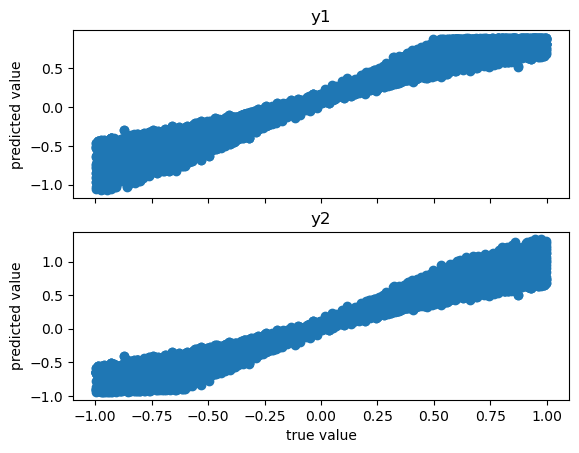

In [6]:
# tf.random.set_seed(42) 

# Model trained on Augmented dataset
# Now we have one input layer, 1 hidden layer and 2 output layer - both connected to hidden layer
# Thinking of adding a normalization layer or doing normalization before training
# inputs = tf.keras.layers.Normalization(input_shape=[4,], axis=None)
inputs = tf.keras.Input(shape=(4,))
dense1 = tf.keras.layers.Dense(4, activation='relu')
# dense2_1 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y2')

# dense2_1 = tf.keras.layers.Dense(1, name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, name = 'y2')
dense2_1 = tf.keras.layers.Dense(2)

x=dense1(inputs)

outputs1=dense2_1(x)
# outputs2=dense2_2(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs1, name = 'leakge_aug_functional_model')

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.mean_squared_error,
              metrics = [tf.keras.metrics.MeanSquaredError()]
)

# y_aug = {
#     "y1" : Y_train_Aug[:,0],
#     "y2" : Y_train_Aug[:,1]
# }

# y_aug_valid = {
#     "y1" : Y_validation_Aug[:,0],
#     "y2" : Y_validation_Aug[:,1]
# }


model.fit(X_train_Aug, y=Y_train_Aug, epochs=5, batch_size=5, verbose=2, validation_data=(X_validation_Aug, Y_validation_Aug))

predictions = model.predict(X_validation_Aug)

# even for a primilinary result, the loss is pretty good

prediction_accuracy(predictions, Y_validation_Aug)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 hidden_layer (Hidden_layer)  (None, 1, 4)             16        
                                                                 
 my_re_lu (MyReLU)           (None, 1, 4)              0         
                                                                 
 output_layer (Output_layer)  (None, 1, 2)             8         
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
20/20 - 1s - loss: 0.3408 - accuracy: 0.6100 - val_loss: 0.3293 - val_accuracy: 0.9500 - 659ms/epoch - 33ms/step
Epoch 2/100
20/20 - 0s - loss: 0.3429 - accuracy: 0.9200 - val_loss: 0.3

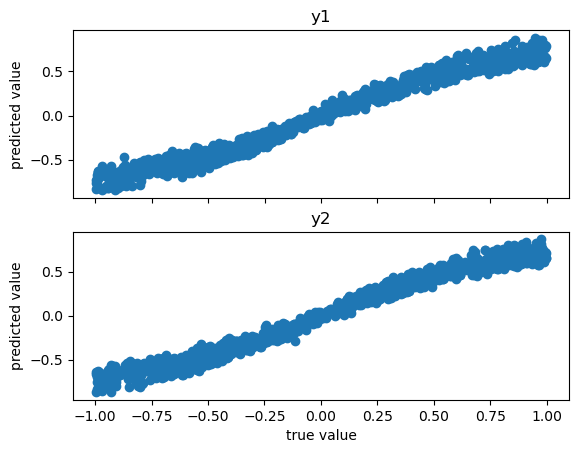

In [7]:
# Equivariant NN - by averaging weights
# how to make constraint work on subclassing api
# Equivariance NN with subclassing API - experiment with layer constraint
# These function make use of the subclassing Api and custom layer functionality of tensorflow
# experiment

class Hidden_layer(layers.Layer):
    def __init__(self, units, kernel_constraint):
        super(Hidden_layer, self).__init__()
        self.units = units
        self.kernel_constraint = kernel_constraint

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], self.units),initializer=tf.keras.initializers.GlorotNormal, trainable=True, constraint=self.kernel_constraint)
            
    def call(self, inputs):
        x = tf.matmul(inputs, self.W)
        return x

class Hidden_layer_constraint(tf.keras.constraints.Constraint):
    # def __init__(self):
    #     self.d = None

    # @tf.function
    def __call__(self, w):
        a = tf.reduce_mean([w[0,0], w[1,1], w[2,2], w[3,3]])
        b = tf.reduce_mean([w[0,1], w[1,0], w[1,2], w[2,1], w[0,3], w[3,0], w[2,3], w[3,2]])
        c = tf.reduce_mean([w[0,2], w[1,3], w[2,0], w[3,1]])
        # a = tf.reduce_mean(w)
        # b = tf.reduce_mean(w)+1
        # c = tf.reduce_mean(w)+2
        
        row_indices = tf.constant([0, 1, 2, 3])
        col_indices = tf.constant([0, 1, 2, 3])
        w = tf.tensor_scatter_nd_update(w, tf.stack([row_indices, col_indices], axis=1), tf.repeat(a, tf.shape(row_indices)[0]))

        row_indices = tf.constant([0, 0, 1, 1, 2, 2, 3, 3])
        col_indices = tf.constant([1, 3, 2, 0, 1, 3, 0, 2])
        w = tf.tensor_scatter_nd_update(w, tf.stack([row_indices, col_indices], axis=1), tf.repeat(b, tf.shape(row_indices)[0]))

        row_indices = tf.constant([0, 1, 3, 2])
        col_indices = tf.constant([2, 3, 1, 0])
        w = tf.tensor_scatter_nd_update(w, tf.stack([row_indices, col_indices], axis=1), tf.repeat(c, tf.shape(row_indices)[0]))

        return w

class Output_layer_constraint(tf.keras.constraints.Constraint):
    # def __init__(self):
    #     self.d = None

    # @tf.function
    def __call__(self, w):
        self.d = tf.reduce_mean(w)
        w = w/w * self.d
        row_indices = tf.constant([0, 1, 1, 2])
        col_indices = tf.constant([1, 0, 1, 0])
        w = tf.tensor_scatter_nd_update(w, tf.stack([row_indices, col_indices], axis=1), tf.repeat(-self.d, tf.shape(row_indices)[0]))
        return w

class Output_layer(layers.Layer):
    def __init__(self, units, kernel_constraint):
        super(Output_layer, self).__init__()
        self.units = units
        self.kernel_constraint = kernel_constraint

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], self.units),initializer=tf.keras.initializers.GlorotNormal, trainable=True, constraint=self.kernel_constraint
        )

    def call(self, inputs):
        x = tf.matmul(inputs, self.W)
        return x

class MyReLU(layers.Layer):
    def __init__(self):
        super(MyReLU, self).__init__()

    def call(self, x):
        return tf.math.maximum(x, 0)

class MyModel(keras.Model):  # model.fit, model.evalute, model.predict
    def __init__(self):
        super(MyModel, self). __init__()
        self.dense1 = Hidden_layer(4, kernel_constraint=Hidden_layer_constraint())
        # self.dense2_1 = tf.keras.layers.Dense(2, kernel_constraint=Output_layer_constraint())
        self.dense2_1 = Output_layer(2, kernel_constraint=Output_layer_constraint())
        self.relu = MyReLU()

    def call(self, x):
        x = self.relu(self.dense1(x))
        # return {"y1" :self.dense2_1(x),"y2" : self.dense2_2(x)}
        return self.dense2_1(x)

    def build_graph(self):
        x = tf.keras.layers.Input(shape=(1,4))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

model = MyModel()
model.build_graph().summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='mean_squared_error',
              metrics = ['accuracy']
)

model.fit(X_train, Y_train, epochs=100, batch_size=5, verbose=2, validation_data=(X_validation, Y_validation))

print("output layer weight matrix")
print(model.layers[1].weights)

print("Hidden layer weight matrix")
print(model.layers[0].weights)

predictions = model.predict(X_validation)
prediction_accuracy(predictions, Y_validation)

In [8]:
# idea to explore - 
# 1. return only a,b,c from the layer then in the forward pass declare the weight matrix and do the layer operation
# 2. return only a,b,c from the layer and then in the constraint declare the weight matrix

In [9]:
# # Not important Experiment 2 - learned how to make a neural network with subclassing api
# # These function make use of the subclassing Api and custom layer functionality of tensorflow
# # experiment

# class Hidden_layer(layers.Layer):
#     def __init__(self, units):
#         super(Hidden_layer, self).__init__()
#         self.units = units

#     def build(self, input_shape):
#         self.a = self.add_weight(shape=(1,), initializer=tf.keras.initializers.GlorotNormal, trainable=False)
#         self.b = self.add_weight(shape=(1,), initializer=tf.keras.initializers.GlorotNormal, trainable=False)
#         self.c = self.add_weight(shape=(1,), initializer=tf.keras.initializers.GlorotNormal, trainable=False)
#         x= tf.Variable(
#             [self.a, self.b, self.c, self.b, 
#              self.b, self.a, self.b, self.c, 
#              self.c, self.b, self.a, self.b, 
#              self.b, self.c, self.b, self.a])
#         x = tf.reshape(x, shape=(input_shape[-1],self.units))
#         self.W = tf.Variable(x, shape=(input_shape[-1],self.units),trainable=True)
#     def call(self, inputs):
#         # print(self.W.shape)
#         # print(inputs.shape)
#         # # print("a")
#         x = tf.matmul(inputs, self.W)
#         # print("b")
#         # print(x)
#         # print(x.shape)
#         return x

# class Output_layer(layers.Layer):
#     def __init__(self, units):
#         super(Output_layer, self).__init__()
#         self.units = units

#     def build(self, input_shape):
#         self.d = self.add_weight(shape=(1,), initializer=tf.keras.initializers.GlorotNormal, trainable=False)
#         x = tf.Variable([self.d,-self.d,-self.d,self.d, -self.d,-self.d,self.d,self.d])
#         x = r = tf.reshape(x, shape=(input_shape[-1],self.units))
#         self.W = tf.Variable(x, shape=(input_shape[-1],self.units),trainable=True)
        
#         # self.W = tf.Variable(
#         #     [[self.d,-self.d],
#         #     [-self.d,-self.d], 
#         #      [-self.d,-self.d],
#         #      [self.d,self.d]],shape=(input_shape[-1],self.units),
#         #     trainable=True)

#     def call(self, inputs):
#         # inputs = inputs
#         # W = self.W.transpose()
#         # print(self.W.shape)
#         # print(inputs.shape)
#         # print("a")
#         x = tf.matmul(inputs, self.W)
#         # print("b")
#         # print(x.shape)
#         return x

# class MyReLU(layers.Layer):
#     def __init__(self):
#         super(MyReLU, self).__init__()

#     def call(self, x):
#         return tf.math.maximum(x, 0)

# class MyModel(keras.Model):  # model.fit, model.evalute, model.predict
#     def __init__(self):
#         super(MyModel, self).__init__()
#         self.dense1 = Hidden_layer(4)
#         self.dense2_1 = Output_layer(2)
#         # self.dense2_2 = Output_layer(1)
#         self.relu = MyReLU()

#     def call(self, x):
#         x = self.relu(self.dense1(x))
#         # return {"y1" :self.dense2_1(x),"y2" : self.dense2_2(x)}
#         return self.dense2_1(x)

#     def build_graph(self):
#         x = tf.keras.layers.Input(shape=(1,4))
#         return tf.keras.Model(inputs=[x], outputs=self.call(x))

# model = MyModel()
# model.build_graph().summary()

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
#               loss='mean_squared_error',
#               metrics = [tf.keras.metrics.MeanSquaredError()]
# )

# model.fit(X_train, y=Y_train, epochs=5, batch_size=5, verbose=2)

# print("output layer weight")
# print(model.layers[1].weights)

# print("hidden layer weight")
# print(model.layers[0].weights)

# predictions = model.predict(X_validation)
# prediction_accuracy(predictions, Y_validation)

In [10]:
# # Not important Experiment 3 - learned how to give custom kernel constraint
# # how to make constraint work on subclassing api
# # Equivariance NN with subclassing API - experiment with layer constraint
# # These function make use of the subclassing Api and custom layer functionality of tensorflow
# # experiment

# class Hidden_layer(layers.Layer):
#     def __init__(self, units):
#         super(Hidden_layer, self).__init__()
#         self.units = units

#     def build(self, input_shape):
#         self.W = self.add_weight(
#             shape=(input_shape[-1], self.units),initializer=tf.keras.initializers.GlorotNormal, trainable=True)
            
#     def call(self, inputs):
#         x = tf.matmul(inputs, self.W)
#         return x

# class Output_layer_constraint(tf.keras.constraints.Constraint):
#     # def __call__(self, d):
#     #     self.d = d
#     def __call__(self, w):
#         # x = tf.Variable([self.d,-self.d,-self.d,self.d, -self.d,-self.d,self.d,self.d])
#         # w = tf.reshape(x, shape=(4.4))
    
#         return w/w

# class Output_layer(layers.Layer):
#     def __init__(self, units, kernel_constraint):
#         super(Output_layer, self).__init__()
#         self.units = units
#         self.kernel_constraint = kernel_constraint

#     def build(self, input_shape):
#         self.W = self.add_weight(
#             shape=(input_shape[-1], self.units),initializer=tf.keras.initializers.GlorotNormal, trainable=True, constraint=self.kernel_constraint
#         )

#     def call(self, inputs):
#         x = tf.matmul(inputs, self.W)
#         return x

# class MyReLU(layers.Layer):
#     def __init__(self):
#         super(MyReLU, self).__init__()

#     def call(self, x):
#         return tf.math.maximum(x, 0)

# class MyModel(keras.Model):  # model.fit, model.evalute, model.predict
#     def __init__(self):
#         super(MyModel, self).__init__()
#         self.dense1 = Hidden_layer(4)
#         # self.dense2_1 = tf.keras.layers.Dense(2, kernel_constraint=Output_layer_constraint())
#         self.dense2_1 = Output_layer(2, kernel_constraint=Output_layer_constraint())
#         self.relu = MyReLU()

#     def call(self, x):
#         x = self.relu(self.dense1(x))
#         # return {"y1" :self.dense2_1(x),"y2" : self.dense2_2(x)}
#         return self.dense2_1(x)

#     # def build_graph(self):
#     #     x = tf.keras.layers.Input(shape=(1,4))
#     #     return tf.keras.Model(inputs=[x], outputs=self.call(x))

# model = MyModel()
# # model.build_graph().summary()

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
#               loss='mean_squared_error',
#               metrics = [tf.keras.metrics.MeanSquaredError()]
# )

# model.fit(X_train, y=Y_train, epochs=5, batch_size=5, verbose=2)
# print(model.layers[1].weights)
